In [1]:
import copy
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Exploring Messari API

In [2]:
#Metadata for top 50 cryptocurrencies by market cap
url = "https://data.messari.io/api/v2/assets?limit=50"
meta_data = requests.get(url).json()['data']

#Storing top 50 crypto's symbol and slug (unique identifier)
crypto_map_dict = {}

for data in meta_data:
    crypto_map_dict[data['symbol']] = data['slug']

#Writing symbol: slug to json for future reference
with open("crypto_symbol.json", "w") as outfile:
    json.dump(crypto_map_dict, outfile)

In [17]:
#Getting the list of time series data available
url = "https://data.messari.io/api/v1/assets/metrics"
metrics_data = requests.get(url).json()['data']['metrics']

#Storing the metric ID and description as a key, value pair
metric_dict = {}

for data in metrics_data:
    metric_dict[data['metric_id']] = []
    metric_dict[data['metric_id']].append(data['name'])
    metric_dict[data['metric_id']].append(data['description'])

In [3]:
#Getting the list of time series data available
url = "https://data.messari.io/api/v1/assets/metrics"
metrics_data = requests.get(url).json()['data']['metrics']

#Dict to store metric ID: description of time series that are free (i.e. not behind a paywall)
free_metric_dict = {}

for i in range(len(metrics_data)):

    mid = metrics_data[i]['metric_id']
    api_url = f"https://data.messari.io/api/v1/assets/bitcoin/metrics/{mid}/time-series"
    temp = requests.get(api_url).json()
    
    #paid metrics only contain status with no data value
    if len(temp)==2:
        free_metric_dict[metrics_data[i]['metric_id']] = metrics_data[i]['description']

    #Throttling to avoid API limit timeout
    if i%10==0:
        time.sleep(45)

#Writing free metric ID: description for future reference
with open("free_metrics.json", "w") as outfile:
    json.dump(free_metric_dict, outfile)

In [2]:
#Reading in free metric json file
with open("free_metrics.json", "r") as infile:
    free_metric_dict = json.load(infile)

In [7]:
#Subjectively selected useful metrics from free metrics list

useful_metric_dict = {
    "px_vol": ['price', 'real.vol', 'mcap.out', 'mcap.circ', 'mcap.realized'], 
    "tokenomics": ['mcap.dom', 'nvt.adj.90d.ma', 'iss.rate'],
    "coin_supply": ['sply.total.iss.ntv', 'sply.circ', 'sply.out', 'new.iss.usd', 'new.iss.ntv'], 
    "blockchain": ['act.addr.cnt', 'hashrate', 'blk.size.bytes.avg'], 
    "transaction": ['txn.vol', 'txn.tfr.val.med.ntv', 'txn.fee.avg', 'fees'], 
    "miner": ['min.rev.ntv', 'min.rev.usd'], 
    "exchange_flow": ['exch.flow.out.usd', 'exch.flow.in.usd', 'exch.flow.in.ntv', 'exch.flow.out.ntv', 'exch.sply'], 
    "social_media": ['reddit.subscribers', 'reddit.active.users'] 
}

Descriptions of these metrics can be found in the free_metrics.json file. For example, some of the less obvious metric IDs are:
- nvt.adh.90d.ma: The ratio of the network value (or market capitalization, current supply) to the 90-day moving average of the adjusted transfer value.
- iss.rate: The percentage of new native units (continuous) issued over that interval, extrapolated to one year (i.e., multiplied by 365), and divided by the current supply at the end of that interval. Also referred to as the annual inflation rate.
- act.addr.cnt: The sum count of unique addresses that were active in the network.
- txn.tfr.val.med.ntv: The median count of native units transferred per transfer (i.e., the median size of a transfer) between distinct addresses that interval.
- exch.flow.in.ntv.incl: The amount of the asset sent to exchanges that interval, including exchange to exchange activity.

# Data extracting functions

In [3]:
def extract_crypto_data(symbol, metrics_list, start, end):
    
    #Store each metric time series as a df within a list
    df_list = []

    for metric in metrics_list:
        
        api_url = f"https://data.messari.io/api/v1/assets/{symbol}/metrics/{metric}/time-series?start={start}&end={end}&interval=1d"
        raw = requests.get(api_url).json()
        
        exit_count = 0
        while 'data' not in raw:
            #Throttling to avoid API limit timeout 
            time.sleep(45)
            raw = requests.get(api_url).json()

            #Proceed to next metric after 3 failed attempts
            exit_count += 1
            if exit_count>=3:
                return "data extraction timeout"

        #API returns time series within json dictionary
        df = pd.DataFrame(raw['data']['values'])
        
        if metric=='price':
            #The price time series contains date and OHLCV data
            df = df.rename(columns = {0:'date',1:'open',2:'high',3:'low',4:'close',5:'volume'})
            #Date reference for non-existing metrics later on
            standard_dates = df['date']
        else:
            #Rest of the time series contain only date and single column metric
            df = df.rename(columns = {0:'date',1:metric})
        
        #Certain metrics are not available for certain cryptocurrencies
        if df.empty:
            #Include a column of NAs for metrics that are not available
            df = pd.DataFrame(np.nan, index=range(len(standard_dates)), columns=[metric])
            df['date'] = standard_dates
        
        #Converting UNIX timestamp to datetime 
        df['date'] = pd.to_datetime(df['date'], unit = 'ms')
        df = df.set_index('date')
        df_list.append(df)
    
    #Combine different metrics into a single dataframe
    return pd.concat(df_list, axis=1)

In [4]:
#Main data extraction function for multiple cryptocurrencies
def get_crypto_data(symbol_list=['bitcoin', 'ethereum'], metrics_list=[], start_date='2020-01-01', end_date='2021-12-30'):

    if len(metrics_list)==0:
        #Default selected free metric list (incomplete) available
        metrics_list = ['price', 'mcap.dom', 'mcap.out', 'mcap.circ', 'mcap.realized', \
        'sply.circ', 'nvt.adj.90d.ma', 'txn.tfr.val.med.ntv', 'txn.fee.avg', 'fees']

    #Storing crypto symbol: metrics df as a key-value pairs
    store_dict = {}    

    for symbol in symbol_list:
        df = extract_crypto_data(symbol, metrics_list, start_date, end_date)
        store_dict[symbol] = df

    return store_dict

In [7]:
#Example list of crypto that we might be interested in
symbol_list = ['bitcoin', 'ethereum', 'solana', 'cardano', 
    'binance-coin', 'ftx-token', 'crypto-com-chain',
    'thesandbox', 'decentraland', 'axie-infinity',
    'vechain', 'chainlink', 'polygon',
    'uniswap', 'polkadot',
    'usd-coin', 'tether', 'dai',
    'monero', 'dogecoin']

#Calling data extracting function
res_dict = get_crypto_data(symbol_list)

#Saving extracted data to a CSV for future use
for symbol in symbol_list:
    res_dict[symbol].to_csv(f'{symbol}.csv')

In [8]:
#Another way to structure metrics data for one asset
symbol_list = ['bitcoin']
start_date = '2020-01-01'
end_date = '2021-12-30'

met_cat_dict = {}

#Extracting metrics by category for bitcoin
for metcat, metlist in useful_metric_dict.items():
    temp_df = get_crypto_data(symbol_list, metlist, start_date, end_date)
    temp_df = temp_df[symbol_list[0]]
    met_cat_dict[metcat] =  temp_df

# Data visualization for selected metrics for Bitcoin

In [9]:
#Combining dict of df into a single df
df_list = [df for df in met_cat_dict.values()] 
df = pd.concat(df_list ,axis=1)

#Filtering df with interested metrics
int_met = ['close', 'mcap.circ', 'mcap.realized', 'mcap.dom', 'nvt.adj.90d.ma', \
    'iss.rate', 'sply.circ', 'hashrate', 'txn.fee.avg', 'exch.sply', 'reddit.subscribers', 'reddit.active.users']
df = df[int_met]

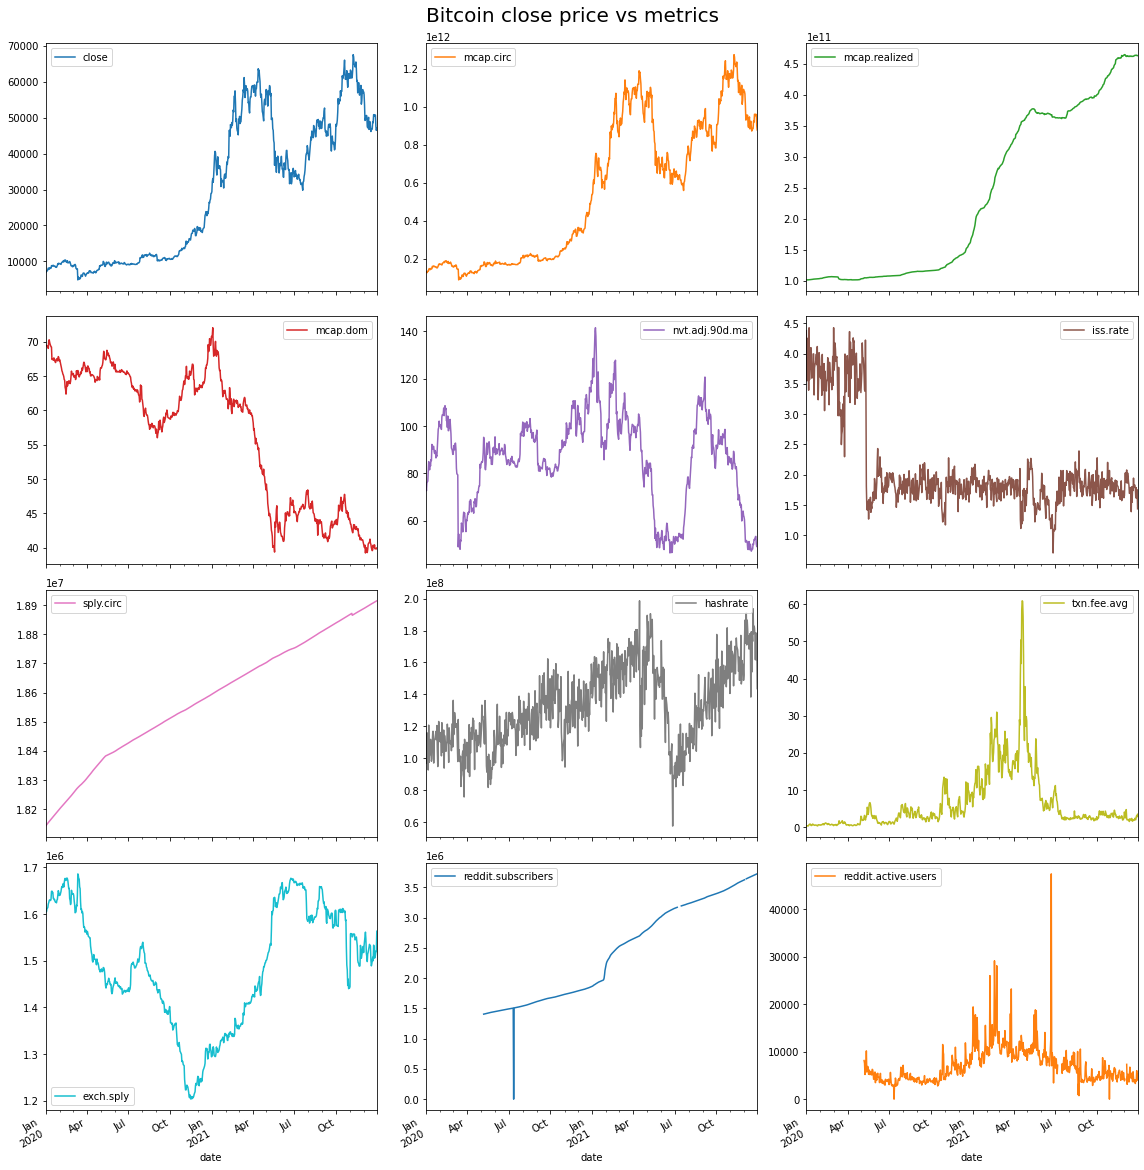

In [11]:
#Plotting bitcoin price against metrics
df.plot(figsize=(16,16), \
    subplots=True, \
        layout=(4,3))

plt.figtext(.5,1,'Bitcoin close price vs metrics', fontsize=20, ha='center')
plt.tight_layout()
plt.show()

The metrics above are selected after filtering out the rest of the highly positively correlated free metrics (not shown). For example, mcap.out (outstanding market cap) and mcap.circ (circulating supply market cap) are the same as the latter accounts for tokens/coins held by projects/foundations which is not applicable in Bitcoin's case. In similar fashion, the miner's revenue in native token (min.rev.ntv) and newly mined tokens (new.iss.ntv) is identical to the iss.rate (inflation rate) apart from the scale of the time series. Transaction fee metrics can be represented by selecting any single one. The exchange flow metrics can also be summarized by the exchange supply metric alone as the net (daily) exchange flow in native tokens moves in tandem with the total exchange supply.

The reddit numbers also have certain erroneous entries with zero data points and gaps on certain days which can probably be fixed by using the previous day value as a proxy for the days with errors. In general, some of the metrics representing a non-cumulative daily interval value are fairly choppy and can probably be smoothened out with a simple moving average.

These metrics are probably quite well-known by now and some of the ways that it is used are as follows:
- Comparing circulating market cap against realized market cap to look for dip buying opportunities
- Using market cap dominance trend to determine if it is altcoin season
- Using the network value to adjusted transfer value to highlight potential over/undervalued opportunities
- Looking out for exchange (coin) supply declines for withdrawals as a precursor for rallies
- Looking at reddit subscriber's growth rate and using active users number as a proxy for short term speculative interest

Overall, the useful free metrics we have are quite limited and probably not so useful in modelling Bitcoin price and it might be more interesting to compare these metrics across assets.

# Comparing metrics across cryptocurrencies

In [10]:
#List of crypto that we are interested in
symbol_list = ['bitcoin', 'ethereum', 'solana', 'cardano', 
    'binance-coin', 'ftx-token', 'crypto-com-chain',
    'thesandbox', 'decentraland', 'axie-infinity',
    'vechain', 'chainlink', 'polygon',
    'uniswap', 'polkadot',
    'monero', 'dogecoin']

int_met = ['price', 'mcap.circ' , 'mcap.realized', 'mcap.dom', 'nvt.adj.90d.ma', 
    'iss.rate', 'sply.circ', 'hashrate', 'txn.fee.avg', 'exch.sply', 'reddit.subscribers', 'reddit.active.users']
    
#Extracting interested metrics for interest cryptocurrencies
res_dict = get_crypto_data(symbol_list=symbol_list, metrics_list=int_met, start_date='2020-01-01', end_date='2021-12-30')

In [11]:
#Dict of metric df
int_met_dict = {}

#Using close price out of OHLC
int_met[0] = 'close'

#Reformatting to get df of single metric with columns representing cryptocurrencies
for met in int_met:
    temp_df = pd.concat([df[met] for df in res_dict.values()], axis=1)
    temp_df.columns = res_dict.keys()

    #Drop crypto with less than 50% data available for that particular metric
    drop_cols = temp_df.columns[temp_df.isnull().mean()>0.5]
    temp_df.drop(drop_cols, axis=1, inplace=True)
    
    int_met_dict[met] = temp_df

## Exchange's share of total circulating supply

In [360]:
#Consider only cryptocurrenciees with both circulating supply and exchange supply data (only btc and eth with data)
common_col = np.intersect1d(int_met_dict['exch.sply'].columns, int_met_dict['sply.circ'].columns)

#Compute exchange supply ratio 
exch_sply_ratio_df = int_met_dict['exch.sply'][common_col]/int_met_dict['sply.circ'][common_col]

#Difference in eth and btc exchange supply ratios
exch_sply_ratio_df['eth-btc_esr'] = exch_sply_ratio_df['ethereum'] - exch_sply_ratio_df['bitcoin']

#Eth/Btc spread price
exch_sply_ratio_df['eth/btc_px'] = int_met_dict['close']['ethereum']/int_met_dict['close']['bitcoin']

#Resample into weekly timeframe
w_exch_sply_ratio_df = exch_sply_ratio_df.resample('w').last()

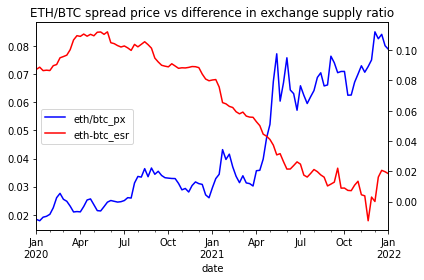

In [321]:
fig = plt.figure()
plt.title("ETH/BTC spread price vs difference in exchange supply ratio")

ax1 = w_exch_sply_ratio_df['eth/btc_px'].plot(color='blue')
ax2 = w_exch_sply_ratio_df['eth-btc_esr'].plot(color='red', secondary_y=True)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles, labels, loc='center left')
plt.tight_layout()
plt.show()

In [361]:
#Net weekly change in the eth-btc exchange supply ratio
w_exch_sply_ratio_df['eth-btc_esr_change'] = w_exch_sply_ratio_df['eth-btc_esr'].diff()

#Weekly percentage change in eth/btc spread price
w_exch_sply_ratio_df['eth/btc_px_change'] = w_exch_sply_ratio_df['eth/btc_px'].pct_change()

#Next period/week percentage change in eth/btc spread price
w_exch_sply_ratio_df['eth/btc_px_t1_change'] = w_exch_sply_ratio_df['eth/btc_px_change'].shift(-1)

#Drop first and last row of df with NA
w_exch_sply_ratio_df.dropna(inplace=True)

In [362]:
#25th and 75th percentile of change in eth-btc ESR difference
inc_cutoff =  np.percentile(w_exch_sply_ratio_df['eth-btc_esr_change'], 75)
dec_cutoff =  np.percentile(w_exch_sply_ratio_df['eth-btc_esr_change'], 25)

inc_cond = w_exch_sply_ratio_df['eth-btc_esr_change']>=inc_cutoff
dec_cond = w_exch_sply_ratio_df['eth-btc_esr_change']<=dec_cutoff

#Filtering df to consider periods with large positive/negative change in exchange supply ratio
pos_change_df = w_exch_sply_ratio_df[inc_cond][['eth/btc_px_change', 'eth/btc_px_t1_change']]
neg_change_df = w_exch_sply_ratio_df[dec_cond][['eth/btc_px_change', 'eth/btc_px_t1_change']]

In [375]:
#Combining descriptive stats of spread price change under extreme changes in exchange supply ratio differences
desc_merge_df = pd.merge(pos_change_df.describe(), neg_change_df.describe(), left_index=True, right_index=True)

# Creating hierarchical columns
tuples = (('large_increase', 't0'), ('large_increase', 't1'), ('large_decrease', 't0'), ('large_decrease', 't1'))
new_columns = pd.MultiIndex.from_tuples(tuples, names=['filter', 'spread px change'])
desc_merge_df.columns = new_columns
desc_merge_df

filter           large_increase            large_decrease           
spread px change             t0         t1             t0         t1
count                 26.000000  26.000000      26.000000  26.000000
mean                   0.020866   0.018172       0.052317   0.016700
std                    0.074565   0.074324       0.101672   0.120439
min                   -0.093423  -0.093423      -0.120385  -0.217667
25%                   -0.028302  -0.043312      -0.005315  -0.045793
50%                    0.016863   0.012686       0.036753  -0.009553
75%                    0.066724   0.071989       0.110615   0.091477
max                    0.206173   0.159282       0.292370   0.292370

We see that the exchange supply ratio (ESR) of Ethereum has generally declined faster relative to that of Bitcoin from the beginning of 2020 and the ratio is now at similar levels in recent times. While Ethereum's ESR has declined steadily for these 2 years, Bitcoin saw an increase in its ESR from the beginning of 2021 to July 2021. This period coincided with the sharp rally of Ethereum against Bitcoin around April 2021. Generally, we also see a strong negative correlation (<-0.9) between the ETH/BTC spread price and their ESR difference which might suggest that the latter has some form of predictive value for spread prices.

To check this out, we look at the weekly percentage change in spread price compared to net changes in the ESR difference value. A decrease in the latter means that the ESR for Ethereum has fallen faster than Bitcoin for the week and vice versa. Therefore, we might hypothesize that a decline in ESR difference should forecast a positive return on the Ethereum/Bitcoin spread. We filter out the dataframe to consider only the periods with large (absolute) changes in the ESR and look at the descriptive statistics. t1 refers to the next period (week) spread return to avoid a lookahead bias while t0 is the same week return.

We first consider the large increase filter (i.e. Ethereum's ESR increased relative to Bitcoin), the mean t1 return is slightly higher than that for the large decrease filter. Additionally, the minimum to median values are also generally higher with the increase filter. This might suggest that there is not much value in using a relative decline Ethereum's ESR as a signal on its own for buying the spread. However, the 75th percentile and max values for the large decrease filter is much more positive than the rest and it might perhaps be more useful to combine this with other signals. Additionally, it seems that the ESR difference series seem to coincide rather than lead the spread returns, as the highest average spread gain is made in the same week as when the ESR difference series sees large declines.

## Social media metrics

In [214]:
red_sub_df = copy.deepcopy(int_met_dict['reddit.subscribers'])
red_act_df = copy.deepcopy(int_met_dict['reddit.active.users'])

#Fill in errorneous zero and NaN data points with previous day subscriber number
red_sub_df =  red_sub_df.replace(to_replace=[0, np.nan], method='ffill')
red_sub_df.dropna(axis=0, inplace=True)

#Smoothing active user number with a rolling 30-day MA
red_act_df = red_act_df.rolling(30).mean().ffill()
red_sub_df.dropna(axis=0, inplace=True)

#Drop Binance numbers due to gap in data from moving subreddit in Jul21
red_sub_df.drop(columns=['binance-coin'], inplace=True)
red_act_df.drop(columns=['binance-coin'], inplace=True)

In [215]:
#Monthly change in reddit subscriber numbers
rs_df = red_sub_df.resample('m').last().pct_change()
rs_df.dropna(inplace=True)

#Market cap data of crypto assets with reddit subscriber numbers
mcap_dom_df = copy.deepcopy(int_met_dict['mcap.dom'].resample('m').last().diff())
mcap_dom_df = mcap_dom_df.loc[rs_df.index, rs_df.columns]
mcap_dom_df = mcap_dom_df.shift(-1)

#Getting the top 2 cryptocurrencies with the largest subscriber percentage increase
top_2_rs_change = rs_df.apply(lambda x: x.sort_values(ascending=False)[:2].index.values.tolist(), axis=1)

#Getting the cryptocurrency with the lowest subscriber percentage increase
bot_rs_change = rs_df.idxmin(axis=1)

In [216]:
#Store market cap change data of crypto with largest and smallest increase in subscriber numbers 
sub_mcap_res_df = pd.DataFrame()

for row in mcap_dom_df.iterrows():
    
    #Get the top 2 largest subscriber increase crypto
    top2c = top_2_rs_change.loc[row[0]]
    #Get the smallest subscriber increase crypto
    botc = bot_rs_change.loc[row[0]]

    top_res = row[1][top2c[0]]

    #Handle exception for missing market cap dom data for largest increase crypto
    if pd.isna(top_res):
        top_res = row[1][top2c[1]]        

    bot_res = row[1][botc]
    
    sub_mcap_res_df.loc[row[0], 'top_res'] = top_res
    sub_mcap_res_df.loc[row[0], 'bot_res'] = bot_res

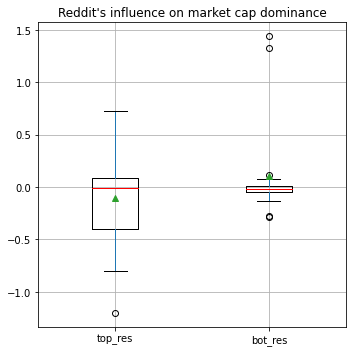

In [245]:
boxprops = dict(linestyle='-', linewidth=1, color='black')
medianprops = dict(linestyle='-', linewidth=1, color='red')

sub_mcap_res_df.boxplot(
    figsize=(5,5), 
    widths=(0.3, 0.3), 
    showmeans=True,
    boxprops=boxprops, 
    medianprops=medianprops)

plt.title("Reddit's influence on market cap dominance")
plt.tight_layout()
plt.show()

In this section, we looked at how the change/increase in reddit subscriber numbers would influence a crypto's market cap dominance. The reddit subscriber number has increased pretty steadily with only one day of a fall in subscriber numbers for dogecoin (unsubscribing is possible on reddit). We use the market cap dominance figure as a measure of relative return as it simply considers the market cap change of the asset of interest against the entire crypto market. The scale of the market cap dominance change is in percentage terms, (e.g. 1.5 could represent an increase in market cap from 8.5% to 10% or 5% to 6.5%).

The boxplot reveals that the dispersion of the next month change in market cap dominance is much wider for the asset with the largest percentage increase in subscriber numbers. This is probably expected as large subscriber interest could represent speculative interest from retail interest. Additionally, there has been an active rotation in the top subscriber increase crypto. From 2020 through 2021, there has been at least 6 different top interested crypto as compared to the bottom interested which only has 3 crypto. Dogecoin is surprisingly one of the bottom 3, as its subscriber increases are concentrated in only a couple of months (Apr/May 21) and remained stagnant for the rest of the year.

Notably, the boxplot for the top interested crypto has a negatively skewed next month market cap dominance which suggests that the flavor/crypto of the month tends to underperform relatively in the next month. The mean of the top interested crypto is also at -0.104 vs the bottom crypto's mean of +0.11. A classic case of "dumb money" piling on at the end and turning into bagholders. For the bottom/least interested crypto, the next period market cap dominance has a couple of outliers on the positive side. It might be a case that least interested crypto are laggards and their role in playing catch up might lead to outsized returns. As a whole, the social media metric might be useful in highlighting mean-reverting opportunities between cryptocurrencies with a suitable timeframe. One might also hypothesize that the mean-reversion will tend to occur on a longer timeframe (e.g. monthly in our case) as opposed to trying it based on weekly numbers.